# Feature Importance Ranking using Fisher Discriminant

This notebook implements feature selection and ranking for algae microscopy classification using the **Fisher Discriminant** (Linear Discriminant Analysis) method.

## Objectives:
1. Extract features from algae images
2. Calculate Fisher scores for each feature
3. Rank features by their discriminative power
4. Visualize feature importance across algae classes

## Fisher Criterion:
For multiple classes, the Fisher score is:

$$F = \frac{\text{Between-class variance}}{\text{Within-class variance}} = \frac{\frac{1}{m-1} \sum_{j=1}^{m} (\mu_j - \bar{\mu})^2}{\frac{1}{m(n-1)} \sum_{j=1}^{m} \sum_{i=1}^{n} (x_{ij} - \mu_j)^2}$$

Where:
- $m$ = number of classes
- $n$ = number of samples per class
- $\mu_j$ = mean of class j
- $\bar{\mu}$ = global mean
- $x_{ij}$ = sample i in class j

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm
import yaml
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load configuration
config_path = Path('../configs/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
data_root = Path('../data')
train_images = data_root / 'train' / 'images'
train_labels = data_root / 'train' / 'labels'

# Class names
class_names = config['data']['classes']
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

Number of classes: 6
Classes: ['Platymonas', 'Chlorella', 'Dunaliella salina', 'Effrenium', 'Porphyridium', 'Haematococcus']


## 1. Feature Extraction

We'll extract multiple features from each algae image:
- **Color features**: Mean RGB, HSV statistics
- **Texture features**: Contrast, homogeneity, energy, correlation (from GLCM)
- **Shape features**: Area, perimeter, circularity, aspect ratio
- **Statistical features**: Standard deviation, skewness, kurtosis

In [3]:
def extract_color_features(image: np.ndarray) -> Dict[str, float]:
    """
    Extract color-based features from image.
    
    Args:
        image: RGB image array
    
    Returns:
        Dictionary of color features
    """
    features = {}
    
    # RGB statistics
    for i, channel in enumerate(['R', 'G', 'B']):
        features[f'mean_{channel}'] = np.mean(image[:, :, i])
        features[f'std_{channel}'] = np.std(image[:, :, i])
        features[f'skew_{channel}'] = float(pd.Series(image[:, :, i].flatten()).skew())
        features[f'kurt_{channel}'] = float(pd.Series(image[:, :, i].flatten()).kurtosis())
    
    # HSV statistics
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    for i, channel in enumerate(['H', 'S', 'V']):
        features[f'mean_{channel}'] = np.mean(hsv[:, :, i])
        features[f'std_{channel}'] = np.std(hsv[:, :, i])
    
    return features


def extract_texture_features(image: np.ndarray) -> Dict[str, float]:
    """
    Extract texture features using Gray Level Co-occurrence Matrix (GLCM).
    
    Args:
        image: RGB image array
    
    Returns:
        Dictionary of texture features
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Reduce to 8 levels for faster computation
    gray = (gray / 32).astype(np.uint8)
    
    features = {}
    
    # Simple texture measures
    features['contrast'] = float(np.std(gray))
    features['energy'] = float(np.sum(gray ** 2) / gray.size)
    
    # Edge detection
    edges = cv2.Canny(gray * 32, 50, 150)
    features['edge_density'] = float(np.sum(edges > 0) / edges.size)
    
    # Gradient features
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gx**2 + gy**2)
    features['gradient_mean'] = float(np.mean(gradient_magnitude))
    features['gradient_std'] = float(np.std(gradient_magnitude))
    
    return features


def extract_shape_features(image: np.ndarray, bbox: List[float]) -> Dict[str, float]:
    """
    Extract shape features from bounding box.
    
    Args:
        image: RGB image array
        bbox: [x_center, y_center, width, height] in normalized coordinates
    
    Returns:
        Dictionary of shape features
    """
    h, w = image.shape[:2]
    
    # Convert normalized to pixel coordinates
    x_center, y_center, box_w, box_h = bbox
    box_w_px = box_w * w
    box_h_px = box_h * h
    
    features = {}
    features['bbox_width'] = float(box_w_px)
    features['bbox_height'] = float(box_h_px)
    features['bbox_area'] = float(box_w_px * box_h_px)
    features['bbox_aspect_ratio'] = float(box_w_px / (box_h_px + 1e-6))
    features['bbox_perimeter'] = float(2 * (box_w_px + box_h_px))
    
    # Circularity approximation
    perimeter = features['bbox_perimeter']
    area = features['bbox_area']
    features['circularity'] = float(4 * np.pi * area / (perimeter ** 2 + 1e-6))
    
    return features


def extract_all_features(image_path: Path, label_path: Path) -> Tuple[List[Dict], List[int]]:
    """
    Extract all features from an image and its labels.
    
    Args:
        image_path: Path to image file
        label_path: Path to YOLO format label file
    
    Returns:
        List of feature dictionaries (one per object)
        List of class IDs
    """
    # Load image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load labels
    features_list = []
    class_ids = []
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            
            class_id = int(parts[0])
            bbox = [float(x) for x in parts[1:5]]
            
            # Extract features
            features = {}
            features.update(extract_color_features(image))
            features.update(extract_texture_features(image))
            features.update(extract_shape_features(image, bbox))
            
            features_list.append(features)
            class_ids.append(class_id)
    
    return features_list, class_ids


print("Feature extraction functions defined!")

Feature extraction functions defined!


In [4]:
# Extract features from all training images
print("Extracting features from training set...")

all_features = []
all_labels = []

image_files = sorted(list(train_images.glob('*.jpg')))

for img_path in tqdm(image_files, desc="Processing images"):
    label_path = train_labels / (img_path.stem + '.txt')
    
    if not label_path.exists():
        continue
    
    try:
        features_list, class_ids = extract_all_features(img_path, label_path)
        all_features.extend(features_list)
        all_labels.extend(class_ids)
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")
        continue

print(f"\nExtracted features from {len(all_features)} algae samples")
print(f"Number of classes: {len(set(all_labels))}")

Extracting features from training set...


Processing images: 100%|██████████| 700/700 [02:54<00:00,  4.01it/s]


Extracted features from 1758 algae samples
Number of classes: 6


In [5]:
# Convert to DataFrame
df_features = pd.DataFrame(all_features)
df_features['class_id'] = all_labels
df_features['class_name'] = df_features['class_id'].map(lambda x: class_names[x])

print(f"Feature matrix shape: {df_features.shape}")
print(f"\nFeature names ({len(df_features.columns) - 2} features):")
print(list(df_features.columns[:-2]))

# Display class distribution
print("\nClass distribution:")
print(df_features['class_name'].value_counts())

Feature matrix shape: (1758, 31)

Feature names (29 features):
['mean_R', 'std_R', 'skew_R', 'kurt_R', 'mean_G', 'std_G', 'skew_G', 'kurt_G', 'mean_B', 'std_B', 'skew_B', 'kurt_B', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V', 'contrast', 'energy', 'edge_density', 'gradient_mean', 'gradient_std', 'bbox_width', 'bbox_height', 'bbox_area', 'bbox_aspect_ratio', 'bbox_perimeter', 'circularity']

Class distribution:
class_name
Chlorella            722
Porphyridium         272
Dunaliella salina    234
Effrenium            227
Platymonas           184
Haematococcus        119
Name: count, dtype: int64


In [6]:
# Display first few samples
df_features.head(10)

,mean_R,std_R,skew_R,kurt_R,mean_G,std_G,skew_G,kurt_G,mean_B,std_B,...,gradient_mean,gradient_std,bbox_width,bbox_height,bbox_area,bbox_aspect_ratio,bbox_perimeter,circularity,class_id,class_name
0,225.100334,16.522474,-2.548427,6.967452,226.595826,16.694753,-2.831693,8.659703,224.006787,16.704922,...,0.498039,1.185178,42.000336,36.999840,1554.005712,1.135149,158.000352,0.782251,4,Porphyridium
1,225.100334,16.522474,-2.548427,6.967452,226.595826,16.694753,-2.831693,8.659703,224.006787,16.704922,...,0.498039,1.185178,37.000432,39.999712,1480.006624,0.925017,154.000288,0.784207,4,Porphyridium
2,225.100334,16.522474,-2.548427,6.967452,226.595826,16.694753,-2.831693,8.659703,224.006787,16.704922,...,0.498039,1.185178,51.000544,39.000160,1989.029376,1.307701,180.001408,0.771435,3,Effrenium
3,225.061977,16.352885,-2.583874,7.205580,226.613242,16.435715,-2.849652,8.832587,224.069719,16.392982,...,0.502454,1.189281,48.999440,42.000032,2057.978048,1.166652,181.998944,0.780752,2,Dunaliella salina
4,225.061977,16.352885,-2.583874,7.205580,226.613242,16.435715,-2.849652,8.832587,224.069719,16.392982,...,0.502454,1.189281,17.000816,16.000128,272.015232,1.062542,66.001888,0.784676,1,Chlorella
5,225.061977,16.352885,-2.583874,7.205580,226.613242,16.435715,-2.849652,8.832587,224.069719,16.392982,...,0.502454,1.189281,15.999312,14.999968,239.989168,1.066623,61.998560,0.784582,1,Chlorella
6,225.267540,16.607393,-2.522932,6.920578,226.723752,16.722175,-2.788550,8.483331,224.288003,16.754870,...,0.491966,1.178729,37.000432,43.000192,1591.025680,0.860471,160.001248,0.780981,2,Dunaliella salina
7,225.267540,16.607393,-2.522932,6.920578,226.723752,16.722175,-2.788550,8.483331,224.288003,16.754870,...,0.491966,1.178729,41.000736,40.999872,1681.024928,1.000021,164.001216,0.785398,2,Dunaliella salina
8,225.267540,16.607393,-2.522932,6.920578,226.723752,16.722175,-2.788550,8.483331,224.288003,16.754870,...,0.491966,1.178729,34.999328,36.000288,1259.985888,0.972196,141.999232,0.785242,4,Porphyridium
9,225.267540,16.607393,-2.522932,6.920578,226.723752,16.722175,-2.788550,8.483331,224.288003,16.754870,...,0.491966,1.178729,41.000736,36.999840,1517.020672,1.108133,156.001152,0.783332,2,Dunaliella salina


## 2. Fisher Discriminant Score Calculation

Now we'll calculate the Fisher score for each feature to determine which features best separate the algae classes.

In [7]:
def calculate_fisher_score(feature_values: np.ndarray, class_labels: np.ndarray) -> float:
    """
    Calculate Fisher Discriminant score for a single feature.
    
    Fisher Score = Between-class variance / Within-class variance
    
    Args:
        feature_values: Array of feature values for all samples
        class_labels: Array of class labels for all samples
    
    Returns:
        Fisher score (higher = better class separation)
    """
    # Get unique classes
    classes = np.unique(class_labels)
    m = len(classes)  # number of classes
    
    # Global mean
    global_mean = np.mean(feature_values)
    
    # Calculate between-class variance (numerator)
    between_class_var = 0.0
    for class_id in classes:
        class_mask = class_labels == class_id
        class_mean = np.mean(feature_values[class_mask])
        between_class_var += (class_mean - global_mean) ** 2
    
    between_class_var /= (m - 1)
    
    # Calculate within-class variance (denominator)
    within_class_var = 0.0
    total_samples = 0
    
    for class_id in classes:
        class_mask = class_labels == class_id
        class_values = feature_values[class_mask]
        class_mean = np.mean(class_values)
        n = len(class_values)
        
        # Sum of squared deviations from class mean
        within_class_var += np.sum((class_values - class_mean) ** 2)
        total_samples += n
    
    within_class_var /= (total_samples - m)
    
    # Fisher score
    if within_class_var == 0:
        return 0.0
    
    fisher_score = between_class_var / within_class_var
    
    return fisher_score


print("Fisher score calculation function defined!")

Fisher score calculation function defined!


In [8]:
# Calculate Fisher scores for all features
print("Calculating Fisher scores for all features...\n")

feature_columns = [col for col in df_features.columns if col not in ['class_id', 'class_name']]
fisher_scores = {}

for feature_name in tqdm(feature_columns, desc="Computing Fisher scores"):
    feature_values = df_features[feature_name].values
    class_labels = df_features['class_id'].values
    
    score = calculate_fisher_score(feature_values, class_labels)
    fisher_scores[feature_name] = score

# Create DataFrame of Fisher scores
df_fisher = pd.DataFrame({
    'Feature': list(fisher_scores.keys()),
    'Fisher_Score': list(fisher_scores.values())
})

# Sort by Fisher score (descending)
df_fisher = df_fisher.sort_values('Fisher_Score', ascending=False).reset_index(drop=True)
df_fisher['Rank'] = df_fisher.index + 1

print(f"\nCalculated Fisher scores for {len(df_fisher)} features")
print("\nTop 10 most discriminative features:")
print(df_fisher.head(10))

Calculating Fisher scores for all features...



Computing Fisher scores: 100%|██████████| 29/29 [00:00<00:00, 3708.94it/s]


Calculated Fisher scores for 29 features

Top 10 most discriminative features:
          Feature  Fisher_Score  Rank
0  bbox_perimeter     10.624767     1
1      bbox_width      9.036763     2
2     bbox_height      9.031463     3
3       bbox_area      7.555700     4
4          kurt_B      0.958910     5
5          skew_B      0.937644     6
6           std_S      0.866320     7
7           std_B      0.506119     8
8     circularity      0.434157     9
9          kurt_R      0.249928    10


## 3. Feature Importance Visualization

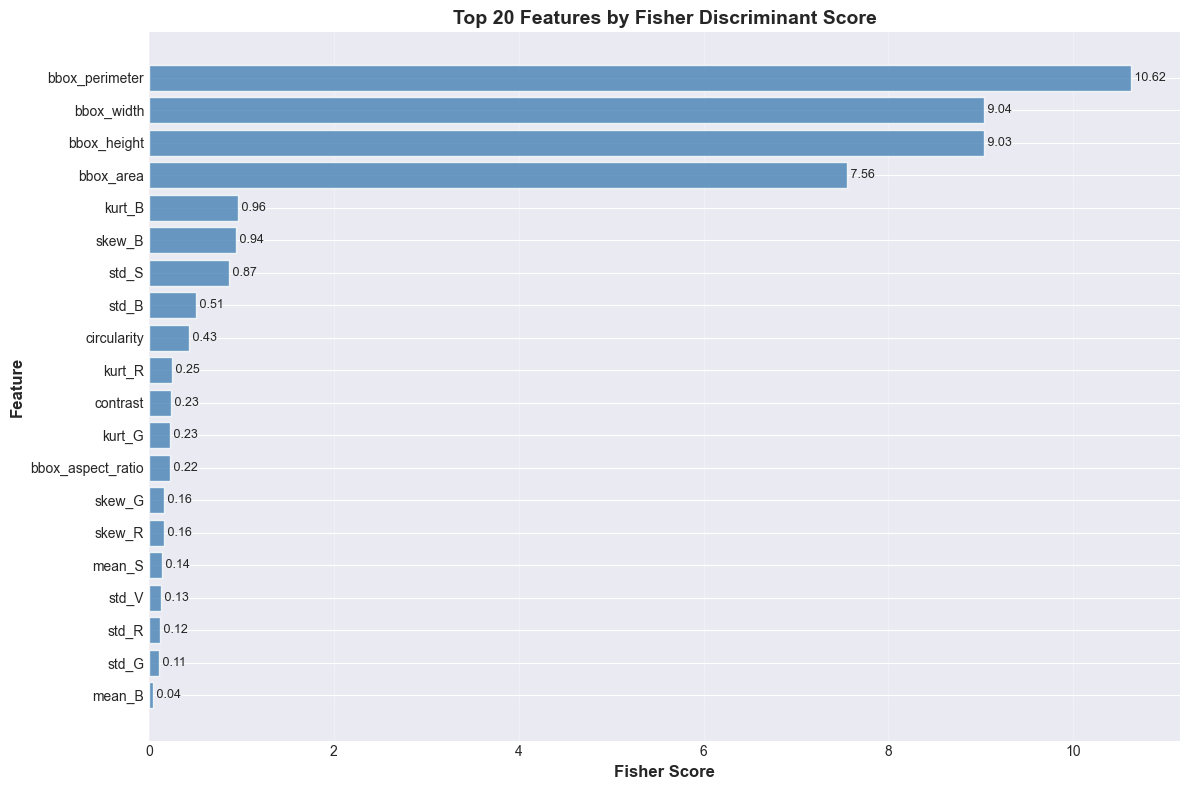


The feature 'bbox_perimeter' has the highest Fisher score: 10.6248


In [9]:
# Plot top 20 features by Fisher score
fig, ax = plt.subplots(figsize=(12, 8))

top_n = 20
top_features = df_fisher.head(top_n)

bars = ax.barh(range(top_n), top_features['Fisher_Score'].values, color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Fisher Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features by Fisher Discriminant Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['Fisher_Score'], i, f" {row['Fisher_Score']:.2f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nThe feature '{top_features.iloc[0]['Feature']}' has the highest Fisher score: {top_features.iloc[0]['Fisher_Score']:.4f}")

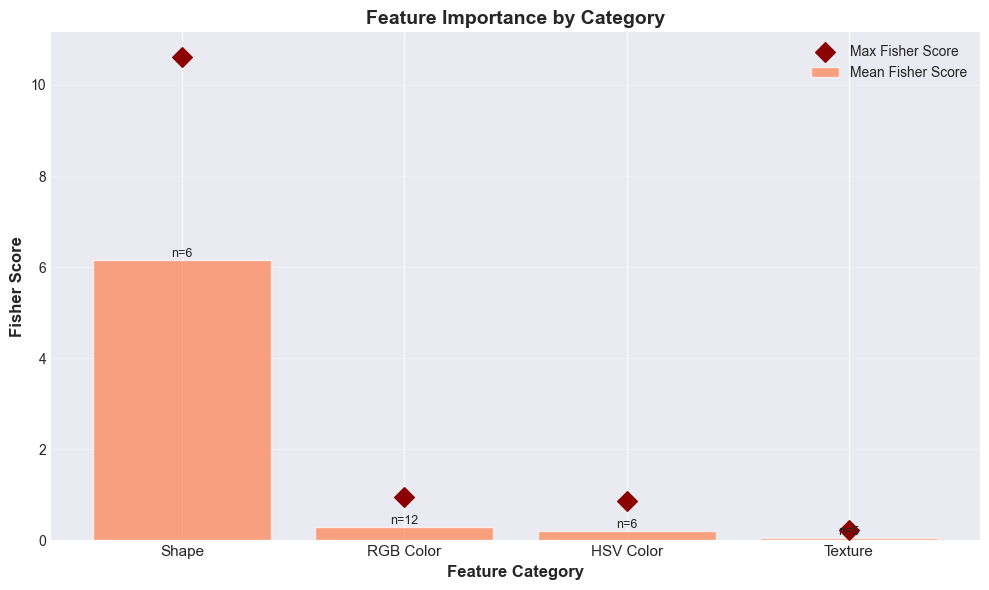


Feature category statistics:
               mean        max  count
Category                             
Shape      6.150887  10.624767      6
RGB Color  0.295814   0.958910     12
HSV Color  0.199389   0.866320      6
Texture    0.054840   0.232488      5


In [10]:
# Categorize features by type
def categorize_feature(feature_name: str) -> str:
    """Categorize feature by type."""
    if any(x in feature_name for x in ['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B', 
                                         'skew_R', 'skew_G', 'skew_B', 'kurt_R', 'kurt_G', 'kurt_B']):
        return 'RGB Color'
    elif any(x in feature_name for x in ['mean_H', 'mean_S', 'mean_V', 'std_H', 'std_S', 'std_V']):
        return 'HSV Color'
    elif any(x in feature_name for x in ['contrast', 'energy', 'edge', 'gradient']):
        return 'Texture'
    elif any(x in feature_name for x in ['bbox', 'area', 'perimeter', 'aspect', 'circularity']):
        return 'Shape'
    else:
        return 'Other'

df_fisher['Category'] = df_fisher['Feature'].apply(categorize_feature)

# Plot Fisher scores by category
fig, ax = plt.subplots(figsize=(10, 6))

category_scores = df_fisher.groupby('Category')['Fisher_Score'].agg(['mean', 'max', 'count'])
category_scores = category_scores.sort_values('mean', ascending=False)

x = range(len(category_scores))
ax.bar(x, category_scores['mean'], alpha=0.7, label='Mean Fisher Score', color='coral')
ax.scatter(x, category_scores['max'], s=100, marker='D', color='darkred', 
           label='Max Fisher Score', zorder=3)

ax.set_xticks(x)
ax.set_xticklabels(category_scores.index, fontsize=11)
ax.set_ylabel('Fisher Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature Category', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add count labels
for i, (cat, row) in enumerate(category_scores.iterrows()):
    ax.text(i, row['mean'], f"n={int(row['count'])}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nFeature category statistics:")
print(category_scores)

## 4. Feature Distribution Analysis

Visualize how the top features separate the different algae classes.

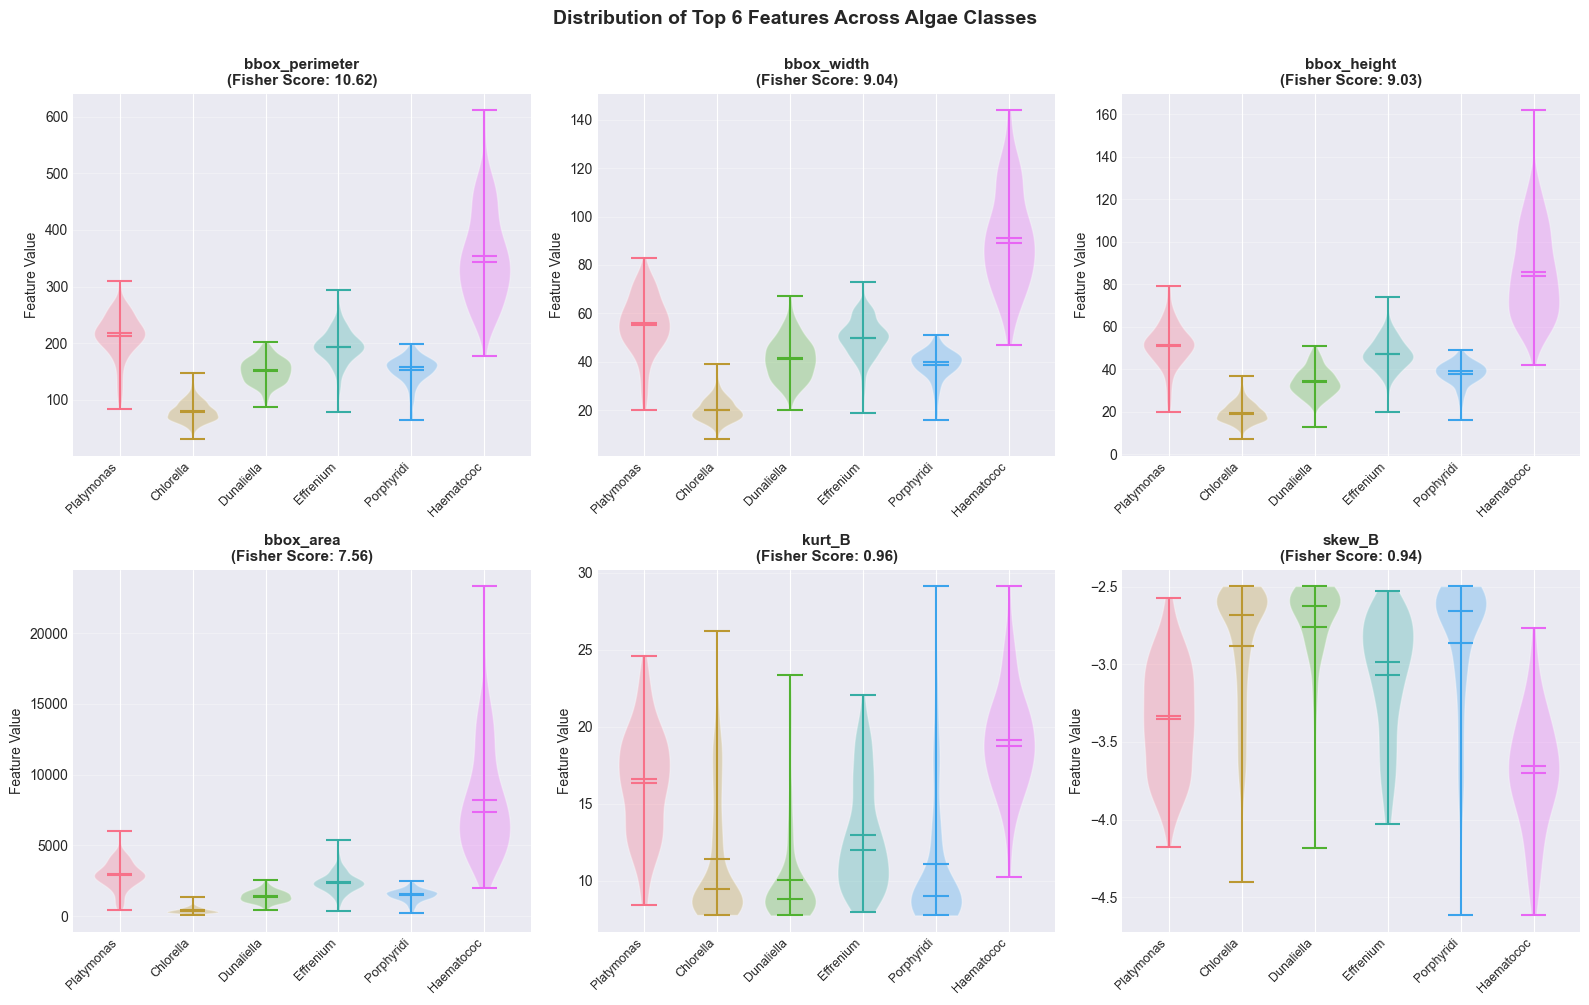

In [11]:
# Plot distribution of top 6 features across classes
top_6_features = df_fisher.head(6)['Feature'].values

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    # Create violin plot
    for class_id, class_name in enumerate(class_names):
        class_data = df_features[df_features['class_id'] == class_id][feature].values
        if len(class_data) > 0:
            parts = ax.violinplot([class_data], positions=[class_id], 
                                   widths=0.7, showmeans=True, showmedians=True)
    
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels([name[:10] for name in class_names], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Feature Value', fontsize=10)
    ax.set_title(f'{feature}\n(Fisher Score: {df_fisher[df_fisher["Feature"] == feature]["Fisher_Score"].values[0]:.2f})', 
                 fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Top 6 Features Across Algae Classes', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

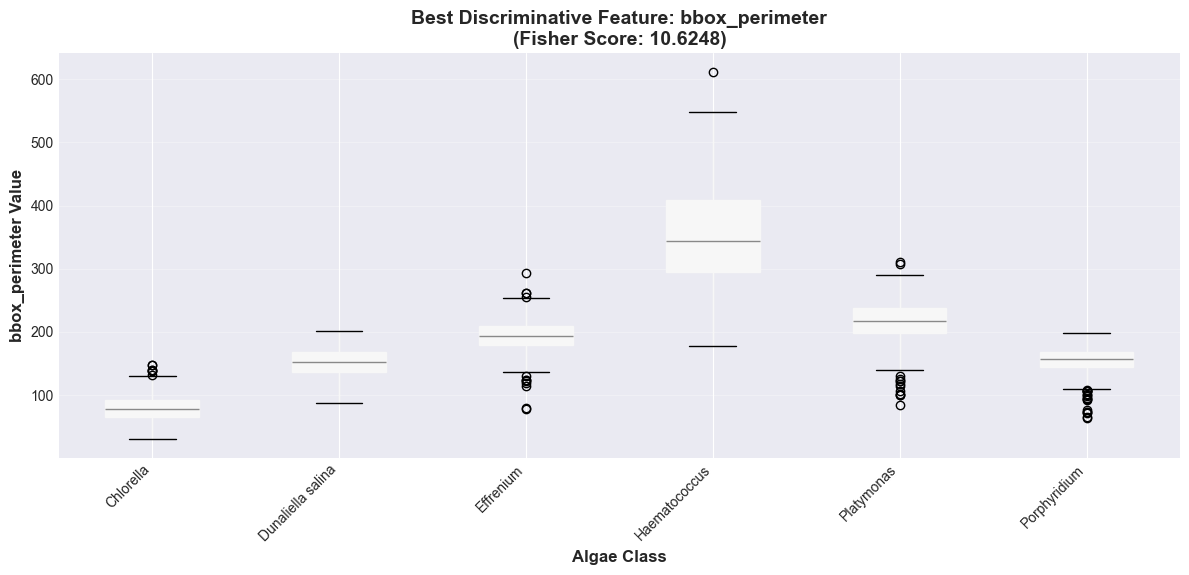


Statistics for best feature 'bbox_perimeter':
                   count        mean        std        min         25%  \
class_name                                                               
Chlorella          722.0   79.590010  18.242220   30.00040   66.000400   
Dunaliella salina  234.0  151.470161  22.156599   88.00104  135.999420   
Effrenium          227.0  193.744533  30.047634   77.99960  179.999112   
Haematococcus      119.0  353.781333  80.184364  178.00000  294.999280   
Platymonas         184.0  213.217371  39.985147   84.00176  198.000964   
Porphyridium       272.0  153.000058  23.925478   64.00040  144.000180   

                          50%         75%         max  
class_name                                             
Chlorella           77.999232   91.998860  148.000544  
Dunaliella salina  152.000200  168.000360  202.001040  
Effrenium          194.000000  210.000400  294.000240  
Haematococcus      344.000000  407.999848  611.998592  
Platymonas         217.9

In [12]:
# Box plot comparison for the best feature
best_feature = df_fisher.iloc[0]['Feature']
best_score = df_fisher.iloc[0]['Fisher_Score']

fig, ax = plt.subplots(figsize=(12, 6))

df_features.boxplot(column=best_feature, by='class_name', ax=ax, patch_artist=True)
ax.set_xlabel('Algae Class', fontsize=12, fontweight='bold')
ax.set_ylabel(f'{best_feature} Value', fontsize=12, fontweight='bold')
ax.set_title(f'Best Discriminative Feature: {best_feature}\n(Fisher Score: {best_score:.4f})', 
             fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics for best feature
print(f"\nStatistics for best feature '{best_feature}':")
print(df_features.groupby('class_name')[best_feature].describe())

## 5. Feature Selection Recommendations

Based on Fisher scores, we can recommend which features to use for classification.

In [13]:
# Create feature selection recommendations
def recommend_features(df_fisher: pd.DataFrame, threshold_percentile: float = 75) -> pd.DataFrame:
    """
    Recommend features based on Fisher score threshold.
    
    Args:
        df_fisher: DataFrame with Fisher scores
        threshold_percentile: Percentile threshold for feature selection
    
    Returns:
        DataFrame of recommended features
    """
    threshold = np.percentile(df_fisher['Fisher_Score'], threshold_percentile)
    recommended = df_fisher[df_fisher['Fisher_Score'] >= threshold].copy()
    
    return recommended, threshold

# Get recommendations
recommended_features, threshold = recommend_features(df_fisher, threshold_percentile=75)

print(f"Feature Selection Recommendations")
print(f"="*60)
print(f"Total features analyzed: {len(df_fisher)}")
print(f"Fisher score threshold (75th percentile): {threshold:.4f}")
print(f"Number of recommended features: {len(recommended_features)}")
print(f"\nRecommended features:")
print(recommended_features[['Rank', 'Feature', 'Fisher_Score', 'Category']].to_string(index=False))

Feature Selection Recommendations
Total features analyzed: 29
Fisher score threshold (75th percentile): 0.5061
Number of recommended features: 8

Recommended features:
 Rank        Feature  Fisher_Score  Category
    1 bbox_perimeter     10.624767     Shape
    2     bbox_width      9.036763     Shape
    3    bbox_height      9.031463     Shape
    4      bbox_area      7.555700     Shape
    5         kurt_B      0.958910 RGB Color
    6         skew_B      0.937644 RGB Color
    7          std_S      0.866320 HSV Color
    8          std_B      0.506119 RGB Color


In [14]:
# Save results to CSV
output_dir = Path('../outputs')
output_dir.mkdir(exist_ok=True)

# Save full Fisher scores
df_fisher.to_csv(output_dir / 'fisher_scores_all_features.csv', index=False)
print(f"Saved all Fisher scores to: {output_dir / 'fisher_scores_all_features.csv'}")

# Save recommended features
recommended_features.to_csv(output_dir / 'recommended_features.csv', index=False)
print(f"Saved recommended features to: {output_dir / 'recommended_features.csv'}")

# Save feature data
df_features.to_csv(output_dir / 'extracted_features.csv', index=False)
print(f"Saved extracted features to: {output_dir / 'extracted_features.csv'}")

Saved all Fisher scores to: ..\outputs\fisher_scores_all_features.csv
Saved recommended features to: ..\outputs\recommended_features.csv
Saved extracted features to: ..\outputs\extracted_features.csv


## 6. Summary and Conclusions

In [15]:
print("="*80)
print("FISHER DISCRIMINANT ANALYSIS - SUMMARY")
print("="*80)
print(f"\n📊 Dataset Statistics:")
print(f"   • Total samples: {len(df_features)}")
print(f"   • Number of classes: {num_classes}")
print(f"   • Features extracted: {len(feature_columns)}")

print(f"\n🏆 Top 5 Most Discriminative Features:")
for i, row in df_fisher.head(5).iterrows():
    print(f"   {row['Rank']}. {row['Feature']:<25} (Score: {row['Fisher_Score']:.4f}, Category: {row['Category']})")

print(f"\n📈 Feature Category Performance:")
for cat, row in category_scores.iterrows():
    print(f"   • {cat:<15}: Mean={row['mean']:.4f}, Max={row['max']:.4f}, Count={int(row['count'])}")

print(f"\n✅ Recommendations:")
print(f"   • Use top {len(recommended_features)} features (above 75th percentile)")
print(f"   • Focus on {category_scores.index[0]} features for best discrimination")
print(f"   • Best single feature: {df_fisher.iloc[0]['Feature']}")

print(f"\n💾 Output Files:")
print(f"   • fisher_scores_all_features.csv")
print(f"   • recommended_features.csv")
print(f"   • extracted_features.csv")
print("="*80)

FISHER DISCRIMINANT ANALYSIS - SUMMARY

📊 Dataset Statistics:
   • Total samples: 1758
   • Number of classes: 6
   • Features extracted: 29

🏆 Top 5 Most Discriminative Features:
   1. bbox_perimeter            (Score: 10.6248, Category: Shape)
   2. bbox_width                (Score: 9.0368, Category: Shape)
   3. bbox_height               (Score: 9.0315, Category: Shape)
   4. bbox_area                 (Score: 7.5557, Category: Shape)
   5. kurt_B                    (Score: 0.9589, Category: RGB Color)

📈 Feature Category Performance:
   • Shape          : Mean=6.1509, Max=10.6248, Count=6
   • RGB Color      : Mean=0.2958, Max=0.9589, Count=12
   • HSV Color      : Mean=0.1994, Max=0.8663, Count=6
   • Texture        : Mean=0.0548, Max=0.2325, Count=5

✅ Recommendations:
   • Use top 8 features (above 75th percentile)
   • Focus on Shape features for best discrimination
   • Best single feature: bbox_perimeter

💾 Output Files:
   • fisher_scores_all_features.csv
   • recommended_fea